# Quantum Phase Estimation

### Initial Imports

In [271]:
import matplotlib.pyplot as plt
import numpy as np
import math
import qiskit_aer

import import_ipynb
#%run EigenvalueInversion.ipynb import *
# %run Encoding.ipynb import *
# %run EigenvalueInversion.ipynb


from qiskit import transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram

### Inverse QFT for use after Unitary Register Hit

In [272]:
def qft_inv(qc,n):
    for  q in range(n//2):
        qc.swap(q,n-q-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)),m,j)
        qc.h(j)

### Qubit Input

In [273]:
#this section you can choose the amount of Qubits you are using
number_of_qubits = 4

## Circuit Setup

In [274]:
qpe = QuantumCircuit(number_of_qubits,number_of_qubits-1)

# samp = [math.randint() for ]
for qubit in qpe:
    qpe = encode_row()




# qpe.x(number_of_qubits-1)
# qpe.draw()



## Hadamard on Qubits

In [275]:
for i in range(number_of_qubits-1):
    qpe.h(i)
qpe.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     └───┘
q_3: ─────
          
c: 3/═════

## Applying Controlled Unitaries

In [276]:
r = 1 # how many times we are repeating argument which
#follows the logic of applying to 2^n extra unitary operations
# to the gate
for num in range(number_of_qubits-1):
    for i in range(r):
        qpe.cp(math.pi/4,num,number_of_qubits-1) # e^ pi/4
    r*=2 #doubling the number of required operation s

qpe.draw()


┌───┐                                                               
q_0: ┤ H ├─■─────────────────────────────────────────────────────────────
     ├───┤ │                                                             
q_1: ┤ H ├─┼────────■────────■───────────────────────────────────────────
     ├───┤ │        │        │                                           
q_2: ┤ H ├─┼────────┼────────┼────────■────────■────────■────────■───────
     └───┘ │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4) 
q_3: ──────■────────■────────■────────■────────■────────■────────■───────
                                                                         
c: 3/════════════════════════════════════════════════════════════════════

## Inverting for Quantum kickback 

In [277]:
qpe.barrier() #barriers are use to seperate a circuit into different optimizations
qft_inv(qpe,number_of_qubits)
qpe.barrier()

for n in range(number_of_qubits-1):
    qpe.measure(n,n)
qpe.draw()

┌───┐                                                                ░    »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────────░──X─»
     ├───┤ │                                                              ░  │ »
q_1: ┤ H ├─┼────────■────────■────────────────────────────────────────────░──┼─»
     ├───┤ │        │        │                                            ░  │ »
q_2: ┤ H ├─┼────────┼────────┼────────■────────■────────■────────■────────░──┼─»
     └───┘ │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  ░  │ »
q_3: ──────■────────■────────■────────■────────■────────■────────■────────░──X─»
                                                                          ░    »
c: 3/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«     ┌───┐                                                            »
«q_0: ┤ H ├─■──────────────■───────────────────■───────────────────────»
«     └───┘ │P(-π/2) ┌───┐ │                   │                       »
«q_1: ──X───■────────┤ H ├─┼─────────■─────────┼──────────────■────────»
«       │            └───┘ │P(-π/4)  │P(-π/2)  │        ┌───┐ │        »
«q_2: ──X──────────────────■─────────■─────────┼────────┤ H ├─┼────────»
«                                              │P(-π/8) └───┘ │P(-π/4) »
«q_3: ─────────────────────────────────────────■──────────────■────────»
«                                                                      »
«c: 3/═════════════════════════════════════════════════════════════════»
«                                                                      »
«                     ░ ┌─┐      
«q_0: ────────────────░─┤M├──────
«                     ░ └╥┘┌─┐   
«q_1: ────────────────░──╫─┤M├───
«                     ░  ║ └╥┘┌─┐
«q_2: ─■──────────────░──╫──╫─┤M├
«      │P(-π/2) ┌───┐ ░  ║  ║ └╥┘
«q_3: ─■────────┤ H ├─░──╫──╫──╫─
«               └───┘ ░  ║  ║  ║ 
«c: 3/═══════════════════╩══╩══╩═
«                        0  1  2

## Simulator

/var/folders/08/l_w4v5hx0331r4f0fnfp7wwc0000gn/T/ipykernel_25884/3067354053.py:5: DeprecationWarning: The function ``qiskit.compiler.assembler.assemble()`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. The `Qobj` class and related functionality are part of the deprecated `BackendV1` workflow,  and no longer necessary for `BackendV2`. If a user workflow requires `Qobj` it likely relies on deprecated functionality and should be updated to use `BackendV2`.
  qobj = assemble(t_qpe,shots=shots)


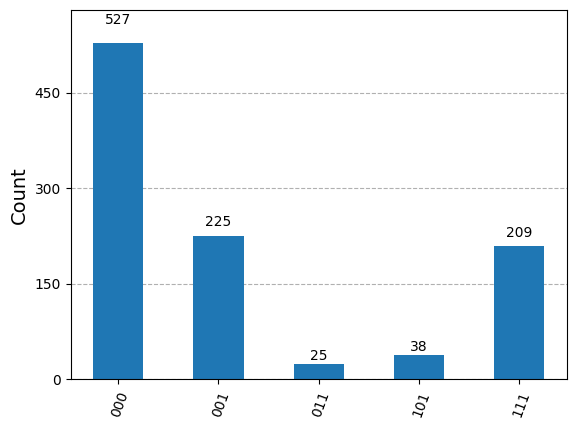

In [278]:
sim = AerSimulator()
shots = 1024
t_qpe = transpile(qpe,sim)

qobj = assemble(t_qpe,shots=shots)
results = sim.run(t_qpe,shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)


## Using heap to format E-values

In [279]:
#e_v_arr=[]#array dedicated to storing eigenvalues

#n^2log(n)
#log()
import heapq
ev_heap = []
heapq.heapify(ev_heap)

for key, item in answer.items():
    dv=int(key,2)#converts str to bin
    phase = dv/2**(number_of_qubits-1)
    evalue = 2 * math.pi *phase
    heapq.heappush(ev_heap,evalue)
    print(f'Eigenvalue,{evalue}: Phase{key}')

heapq.heappop(ev_heap)
#print(ev_heap)
#print(heapq.(ev_heap))

m = n = len(ev_heap)


sig_matrix = [[0 for i in range(m)]for j in range(m)]



print(ev_heap)

for i in range(m-1,-1,-1):
    val = heapq.heappop(ev_heap)
    #sig_matrix[i][i]=val
    sig_matrix[i][i]=math.sqrt(val)
print(np.matrix(sig_matrix))


Eigenvalue,0.7853981633974483: Phase001
Eigenvalue,3.9269908169872414: Phase101
Eigenvalue,0.0: Phase000
Eigenvalue,2.356194490192345: Phase011
Eigenvalue,5.497787143782138: Phase111
[0.7853981633974483, 2.356194490192345, 5.497787143782138, 3.9269908169872414]
[[2.34473605 0.         0.         0.        ]
 [0.         1.98166365 0.         0.        ]
 [0.         0.         1.53499006 0.        ]
 [0.         0.         0.         0.88622693]]


### Now we have the sigma matrix lets reconstruct the SVD Matrix

In [280]:
### Computing the U matrix using the formula ui = Avi/σi
num = len(sig_matrix)#square so doesnt matter which you chose
dimension = num
print(dimension)
matrix = np.random.randint(0,2, size = (dimension,dimension))
print(np.matrix(matrix))
A = np.matmul(matrix, matrix)
#print(np.matrix(A))
#note this allows you to compute the evect for complex hermetian
#numpy.linalg.eigh

# np.linalg.eig(sig_matrix)
matrix = np.random.randint(0,2, size = (dimension,dimension))
#print(matrix)

4
[[1 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 1 1]]


In [281]:

## current implementation is miss the 
#v =[[matrix[i][j]/sig_matrix[i][i] for j in range(num)] for i in range(num)]


matrix = np.random.randint(0,2, size = (dimension,dimension))
print(matrix)

U, burn, Vh = np.linalg.svd(matrix)
print(f"===SIGMA MATRIX COMPARISON====")
print(f"Classic")
print(burn)
print(np.matrix(sig_matrix))
print("===========U-matrix=======")
#print(np.matrix(U))
print("===========∑-matrix=======")
#print(np.matrix(sig_matrix))
print("===========V+-matrix=======")
#print(Vh)

fin= np.matmul(U,sig_matrix,Vh)
print(np.matrix(fin))

[[0 1 0 1]
 [0 1 1 1]
 [1 0 1 1]
 [1 0 0 0]]
===SIGMA MATRIX COMPARISON====
Classic
[2.48704642 1.44597796 0.77036016 0.36096128]
[[2.34473605 0.         0.         0.        ]
 [0.         1.98166365 0.         0.        ]
 [0.         0.         1.53499006 0.        ]
 [0.         0.         0.         0.88622693]]
===========U-matrix=======
===========∑-matrix=======
===========V+-matrix=======
[[-1.06659449 -0.91319042  1.00975431 -0.34092404]
 [-1.53943247 -0.64458328 -0.51524623  0.5246498 ]
 [-1.38525953  1.20620113 -0.38977263 -0.41187155]
 [-0.26714613  1.10574196  0.95874362  0.47357509]]
